# EC-A2: Classify QuickDraw images

### Jing Qian (jq2282)

If you’re up for more image classification, use the ​QuickDraw Loader​ to create a dataset of a bunch of different classes (you can use “animals” to start). Write a CNN to classify these images, and report your accuracy. How accurate of a model can you train to recognize 50 classes? 100? More?

# Step 1. Load the Quick Draw dataset

## Get the data
Start with the group of animals with 42 classes

Delete the class 'sea turtle' because of error

In [0]:
from __future__ import print_function

import functools, itertools, json, os, re, textwrap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from PIL import Image, ImageDraw
from six.moves.urllib import request
from xml.dom import minidom

In [2]:
# Retrieve list of classes.
def list_bucket(bucket, regexp='.*'):
    """Returns a (filtered) list of Keys in specified GCE bucket."""
    keys = []
    fh = request.urlopen('https://storage.googleapis.com/%s' % bucket)
    content = minidom.parseString(fh.read())
    for e in content.getElementsByTagName('Contents'):
        key = e.getElementsByTagName('Key')[0].firstChild.data
        if re.match(regexp, key):
            keys.append(key)
    return keys

all_ndjsons = list_bucket('quickdraw_dataset', '.*ndjson$')
# print('available: (%d)' % len(all_ndjsons))
# print('\n'.join(textwrap.wrap(
#     ' '.join([key.split('/')[-1].split('.')[0] for key in all_ndjsons]),
#     width=100)))

available: (309)
The Eiffel Tower The Great Wall of China The Mona Lisa aircraft carrier airplane alarm clock
ambulance angel animal migration ant anvil apple arm asparagus axe backpack banana bandage barn
baseball bat baseball basket basketball bat bathtub beach bear beard bed bee belt bench bicycle
binoculars bird birthday cake blackberry blueberry book boomerang bottlecap bowtie bracelet brain
bread bridge broccoli broom bucket bulldozer bus bush butterfly cactus cake calculator calendar
camel camera camouflage campfire candle cannon canoe car carrot castle cat ceiling fan cell phone
cello chair chandelier church circle clarinet clock cloud coffee cup compass computer cookie cooler
couch cow crab crayon crocodile crown cruise ship cup diamond dishwasher diving board dog dolphin
donut door dragon dresser drill drums duck dumbbell ear elbow elephant envelope eraser eye
eyeglasses face fan feather fence finger fire hydrant fireplace firetruck fish flamingo flashlight
flip flops floor l

In [0]:
# Store all data locally in this directory.
data_path = 'data'
if not os.path.exists(data_path): 
  os.mkdir(data_path)

In [0]:
# Start with the group of animals
animals = ['bat', 'bird', 'butterfly', 'camel', 'cat', 'cow', 'crab',
           'crocodile', 'dog', 'dolphin', 'duck', 'elephant', 'fish',
           'frog', 'giraffe', 'hedgehog', 'horse', 'kangaroo', 'lion',
           'lobster', 'monkey', 'mosquito', 'mouse', 'octopus', 'owl',
           'panda', 'parrot', 'penguin', 'pig', 'rabbit', 'raccoon',
           'rhinoceros', 'scorpion', 'shark', 'sheep',
           'snail', 'spider', 'squirrel', 'teddy-bear', 'tiger',
           'whale', 'zebra']

classes, classes_name = animals, 'animals'

In [8]:
# Download the chosen group.
def valid_ndjson(filename):
    """Checks presence + completeness of .ndjson file."""
    try:
        json.loads(open(filename).readlines()[-1])
        return True
    except (ValueError, IOError):
        return False

def retrieve(bucket, key, filename):
    """Returns a file specified by its Key from a GCE bucket."""
    url = 'https://storage.googleapis.com/%s/%s' % (bucket, key)
    if not os.path.isfile(filename):
        request.urlretrieve(url=url, filename=filename)
    while not valid_ndjson(filename):
        print('*** Corrupted download (%.2f MB), retrying...' % (os.path.getsize(filename) / 2.**20))
        request.urlretrieve(url=url, filename=filename)

if not os.path.exists(data_path):
    os.mkdir(data_path)

print('\n%d classes:' % len(classes))

for name in classes:
    print(name, end=' ')
    dst = '%s/%s.ndjson' % (data_path, name)
    retrieve('quickdraw_dataset', 'full/simplified/%s.ndjson' % name, dst)
    print('%.2f MB' % (os.path.getsize(dst) / 2.**20))

print('\nDONE :)')


42 classes:
bat 58.02 MB
bird 65.86 MB
butterfly 63.27 MB
camel 54.31 MB
cat 73.12 MB
cow 91.94 MB
crab 76.46 MB
crocodile 57.19 MB
dog 87.06 MB
dolphin 46.29 MB
duck 67.93 MB
elephant 70.86 MB
fish 48.59 MB
frog 92.50 MB
giraffe 58.27 MB
hedgehog 90.76 MB
horse 99.79 MB
kangaroo 96.06 MB
lion 90.47 MB
lobster 86.65 MB
monkey 91.05 MB
mosquito 64.99 MB
mouse 76.35 MB
octopus 79.30 MB
owl 108.10 MB
panda 97.04 MB
parrot 96.42 MB
penguin 137.90 MB
pig 124.13 MB
rabbit 95.05 MB
raccoon 89.36 MB
rhinoceros 92.20 MB
scorpion 104.07 MB
shark 48.55 MB
sheep 80.55 MB
snail 69.58 MB
spider 115.32 MB
squirrel 100.65 MB
teddy-bear 128.27 MB
tiger 86.09 MB
whale 53.94 MB
zebra 92.10 MB

DONE :)


## Inspect the data

In [9]:
# Let's check out the downloaded files...
# !ls -lh $data_path

total 3.5G
-rw-r--r-- 1 root root  59M May  1 18:28 bat.ndjson
-rw-r--r-- 1 root root  66M May  1 18:28 bird.ndjson
-rw-r--r-- 1 root root  64M May  1 18:28 butterfly.ndjson
-rw-r--r-- 1 root root  55M May  1 18:28 camel.ndjson
-rw-r--r-- 1 root root  74M May  1 18:28 cat.ndjson
-rw-r--r-- 1 root root  92M May  1 18:28 cow.ndjson
-rw-r--r-- 1 root root  77M May  1 18:28 crab.ndjson
-rw-r--r-- 1 root root  58M May  1 18:28 crocodile.ndjson
-rw-r--r-- 1 root root  88M May  1 18:28 dog.ndjson
-rw-r--r-- 1 root root  47M May  1 18:28 dolphin.ndjson
-rw-r--r-- 1 root root  68M May  1 18:28 duck.ndjson
-rw-r--r-- 1 root root  71M May  1 18:28 elephant.ndjson
-rw-r--r-- 1 root root  49M May  1 18:28 fish.ndjson
-rw-r--r-- 1 root root  93M May  1 18:28 frog.ndjson
-rw-r--r-- 1 root root  59M May  1 18:28 giraffe.ndjson
-rw-r--r-- 1 root root  91M May  1 18:28 hedgehog.ndjson
-rw-r--r-- 1 root root 100M May  1 18:28 horse.ndjson
-rw-r--r-- 1 root root  97M May  1 18:28 kangaroo.ndjson
-rw-r--r-

In [10]:
# What is the NDJSON file format?
# Seems to be one JSON dictionary per line...
# path = sorted(tf.gfile.Glob(os.path.join(data_path, '*.ndjson')))[1]
# print(open(path).read()[:1000] + '...')

{"word":"bird","countrycode":"US","timestamp":"2017-03-09 00:28:55.63775 UTC","recognized":true,"key_id":"4926006882205696","drawing":[[[0,11,23,50,72,96,97,132,158,224,255],[22,9,2,0,26,45,71,40,27,10,9]]]}
{"word":"bird","countrycode":"US","timestamp":"2017-03-29 04:22:58.82297 UTC","recognized":true,"key_id":"5357674197680128","drawing":[[[65,194,221,240,250,255,251,242,227,210,173,154,133,86,58,55],[102,104,111,120,130,151,161,173,181,184,186,181,170,138,106,94]],[[211,216],[133,138]],[[208,205,205],[154,164,159]],[[94,82,74,74,83,91,106,139,164],[143,165,196,244,250,250,242,211,146]],[[107,108,111,127,155,175,181,181,176,178],[84,53,44,20,2,0,16,52,79,92]],[[42,25,3,0],[94,89,62,39]]]}
{"word":"bird","countrycode":"US","timestamp":"2017-03-17 19:31:28.87981 UTC","recognized":true,"key_id":"5553672849195008","drawing":[[[159,163,175,189,201,209,227,245,253,255],[15,9,2,0,5,16,8,7,15,23]],[[124,108,101,97,96,105,152,159,171,178,179,168,154,140,125],[52,50,55,63,81,93,115,114,101,73,

In [11]:
# # Parse single line.
# data_json = json.loads(open(path).readline())
# data_json.keys()

dict_keys(['word', 'countrycode', 'timestamp', 'recognized', 'key_id', 'drawing'])

In [12]:
# # ...and the actual drawing.
# drawing = data_json['drawing']
# # The drawing consists of a series of strokes:
# [np.array(stroke).shape for stroke in drawing]

[(2, 11)]

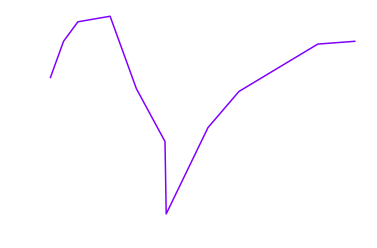

In [13]:
# Draw the image -- the strokes all have have shape (2, n)
# so the first index seems to be x/y coordinate:

def draw_strokes(drawing):
  # Use a different color for each stroke
  colors = cm.rainbow(np.linspace(0, 1, len(drawing)))
  plt.axis('off')
  for stroke, c in zip(drawing, colors):
    #print(stroke[0], stroke[1])
    plt.plot(np.array(stroke[0]), -1 * np.array(stroke[1]), color=c)
    
# draw_strokes(drawing)

In [14]:
# Some more code to load many sketches at once.
# Let's ignore the difficult "unrecognized" sketches for now...
# (i.e. unrecognized by the official quickdraw classifier)

def convert(line):
    """Converts single line to JSON + converts 'drawing' to list of np.array."""
    d = json.loads(line)
    d['drawing'] = [np.array(stroke) for stroke in d['drawing']]
    return d

def loaditer(name, unrecognized=False):
    """Returns iterable of drawings in specified file.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    for line in open('%s/%s.ndjson' % (data_path, name)):
        d = convert(line)
        if d['recognized'] or unrecognized:
            yield d

def loadn(name, n, unrecognized=False):
    """Returns list of drawings.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      n: Number of drawings to load.
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    it = loaditer(name, unrecognized=unrecognized)
    return list(itertools.islice(it, 0, n))

# print('loading some "%s"...' % classes[0])
# sample = loadn(classes[0], 100)

loading some "bat"...


In [15]:
# sample[0]

{'countrycode': 'RO',
 'drawing': [array([[111,  89,  79,  77,  82,  89, 103, 113, 126, 125, 104],
         [ 53, 106, 147, 174, 179, 180, 172, 156, 114,  54,  55]]),
  array([[103, 103, 111, 126, 137, 137, 127],
         [ 53,  17,   1,   2,  14,  25,  44]]),
  array([[113,  98,  45,  41,  40,  45,  27,  22,  21,  25,  20,   2,   0,
            8,  42,  61,  73],
         [ 55,  48,  12,  10,  13,  53,  54,  61,  93, 125, 126, 115, 123,
          136, 165, 167, 158]]),
  array([[132, 143, 158, 171, 208, 215, 219, 248, 251, 255, 254, 242, 227,
          233, 233, 222, 211, 187, 144, 125, 111, 107],
         [ 61,  56,  37,  26,  12,  65,  67,  65,  67,  82, 102, 130, 153,
          156, 160, 173, 180, 188, 189, 189, 186, 181]])],
 'key_id': '5073402912047104',
 'recognized': True,
 'timestamp': '2017-03-07 14:44:14.70063 UTC',
 'word': 'bat'}

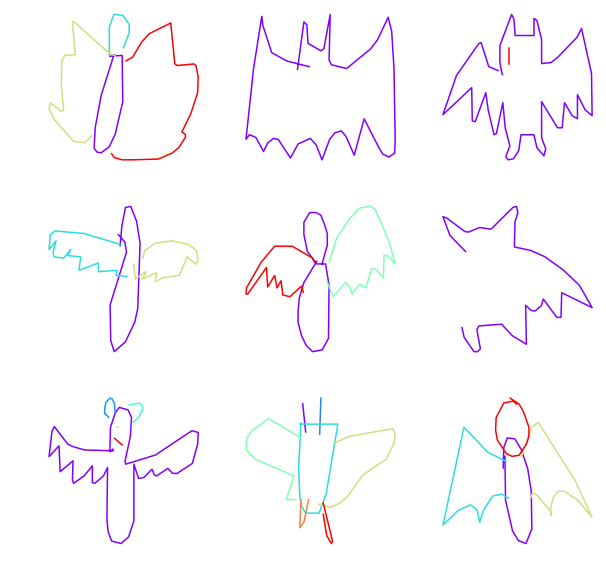

In [16]:
# # Some more drawings...
# plt.figure(figsize=(10, 10))
# n = 3
# for x in range(n):
#     for y in range(n):
#         i = x * n + y
#         plt.subplot(n, n, i + 1)
#         drawing = sample[i]['drawing']
#         draw_strokes(drawing)
        
# # bats!

In [17]:
# Let's first check how many [recognized=True] examples we have in each class.
# Depending on your choice of classes you could generate >200k examples / class...
for name in classes:
    print(name, len(list(open('%s/%s.ndjson' % (data_path, name)))), 'recognized', len(list(loaditer(name))))

bat 118114 recognized 96152
bird 133572 recognized 111611
butterfly 117999 recognized 114549
camel 121399 recognized 115454
cat 123202 recognized 103031
cow 123083 recognized 101099
crab 126930 recognized 106466
crocodile 127932 recognized 106410
dog 152159 recognized 143285
dolphin 121613 recognized 110335
duck 135480 recognized 113764
elephant 126969 recognized 104986
fish 134150 recognized 126420
frog 159047 recognized 145286
giraffe 127182 recognized 122396
hedgehog 120527 recognized 103226
horse 178286 recognized 156302
kangaroo 174470 recognized 152511
lion 120949 recognized 98976
lobster 140175 recognized 118228
monkey 127633 recognized 105650
mosquito 123029 recognized 116609
mouse 178826 recognized 166197
octopus 150152 recognized 143558
owl 169632 recognized 147654
panda 113613 recognized 94814
parrot 185530 recognized 163567
penguin 253791 recognized 231826
pig 186770 recognized 164788
rabbit 155288 recognized 133323
raccoon 119588 recognized 101174
rhinoceros 188484 recogni

## Make images from the brush stroke
Convert sequences of strokes to images

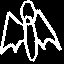

In [19]:
def json_to_img(drawing, img_sz=64, lw=3, maximize=True):
    img = Image.new('L', (img_sz, img_sz))
    draw = ImageDraw.Draw(img)
    lines = np.array([
        stroke[0:2, i:i+2]
        for stroke in drawing
        for i in range(stroke.shape[1] - 1)
    ], dtype=np.float32)
    if maximize:
        for i in range(2):
            min_, max_ = lines[:,i,:].min() * 0.95, lines[:,i,:].max() * 1.05
            lines[:,i,:] = (lines[:,i,:] - min_) / max(max_ - min_, 1)
    else:
        lines /= 1024
    for line in lines:
        draw.line(tuple(line.T.reshape((-1,)) * img_sz), fill='white', width=lw)
    return img
  

#json_to_img(drawing)

raccoon


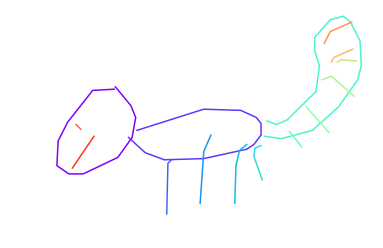

In [20]:
# Fetch some images + shuffle order.
n_per_class = 10000
drawings_matrix = [loadn(name, n_per_class) for name in classes]
drawings_list = functools.reduce(lambda x, y: x + y, drawings_matrix, [])
np.random.seed(1)
drawings_list = np.random.permutation(drawings_list)

# Quick test to see how our code works so far
# draw_strokes(drawings_list[0]['drawing'])
# print(str(drawings_list[0]['word']))

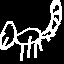

In [21]:
#json_to_img(drawings_list[0]['drawing'])

## Save the images to disk

In [23]:
np.shape(drawings_list)

(420000,)

In [0]:
# Save a dataset to disk
X, y = [], []
for drawing in drawings_list:
  X.append(np.array(json_to_img(drawing['drawing'])))
  y.append(str(drawing['word']))
  
dataset_path = 'mini-quickdraw.npz'
out = open(dataset_path, 'wb') #must open as binary files, or error in python3
# This may take a moment...
np.savez_compressed(out, X, y, X=X, y=y)

In [28]:
# save the dataset to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/mini-quickdraw.npz /content/gdrive/My\ Drive/EC_ADL/mini-quickdraw-42animals.npz

(420000, 64, 64) (420000,)
Label raccoon


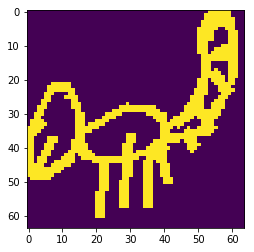

Exception ignored in: <bound method ZipFile.__del__ of <zipfile.ZipFile [closed]>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/zipfile.py", line 1686, in __del__
    self.close()
  File "/usr/lib/python3.6/zipfile.py", line 1703, in close
    self.fp.seek(self.start_dir)
ValueError: I/O operation on closed file.


In [36]:
# Demonstrate loading it back
dataset_path = '/content/gdrive/My Drive/EC_ADL/mini-quickdraw-42animals.npz'
loaded = np.load(open(dataset_path,'rb'))
X, y = loaded["X"], loaded["y"]
print(X.shape, y.shape)
# it worked!
plt.imshow(X[0])
print("Label", y[0])

# Step 2. Classify with CNN